# **IMPORTING LIBRARIES AND DEFINING HYPERPARAMETERS**

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 3000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

torch.manual_seed(1337)

In [2]:
print(device)

cuda


# **GETTING DATA**

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

--2024-06-20 07:14:08--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt'

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-06-20 07:14:08 (16.5 MB/s) - 'input.txt' saved [1115394/1115394]



In [4]:
print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


# **Encoding - CONVERTING CHARACTERS TO NUMBERS(VECTORS)**

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
print(''.join(chars))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [6]:
vocab_size = len(chars)
print(vocab_size)

65


In [7]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hey , whats up"))
print(decode(encode("hey , whats up")))

[46, 43, 63, 1, 6, 1, 61, 46, 39, 58, 57, 1, 59, 54]
hey , whats up


In [8]:
#example

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:200])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59])


# **TRAIN-VAL SPLIT**

In [9]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [10]:
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57,  1, 47, 57,  1, 41, 

# **Funciton for Generating Batches with Input x and Target y**

In [11]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) #last idx value can be len(data) - block_size and we need batch_size no of batches
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# **Loss Function for Mean loss of Training and Val Data**

In [12]:
@torch.no_grad()  # dont save intermediate variables for back prop , better memory utilization
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# **Implementing Self Attention and MultiHead Attention**

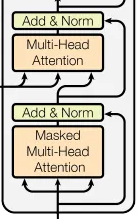

In [13]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)    
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)  #norm

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)  what do i contain
        q = self.query(x) # (B,T,hs)  what i am looking for
        
        # compute attention scores ("affinities")  wei is dot prod of k and q and thus gives more pref to useful char
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)   * for normalisation wei from 
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)  communication with past only 
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs) 
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [14]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)                            

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

# **Feed Forward Neural Network for Computation**

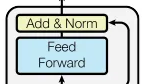

In [15]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), 
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

# **Implementing Blocks**

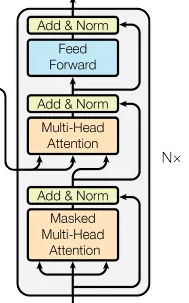

In [16]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head                     #combine diff heads
        self.sa = MultiHeadAttention(n_head, head_size)  #communication
        self.ffwd = FeedFoward(n_embd)                   #computation
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# **The Whole Model Combined**

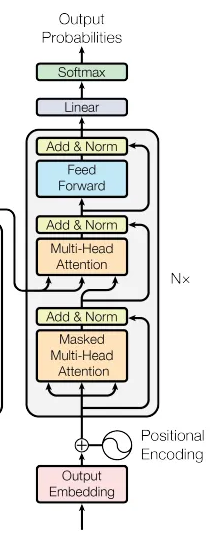

In [17]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])  #communication & computation
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm 
        self.lm_head = nn.Linear(n_embd, vocab_size) # making model bigger 

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T=block_size,C=vocab_size) go to the embedding table and get corresponding embeddings for idx 
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)  # for using the cross entropy loss
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:] # idx doesnt become more than block size
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [18]:
model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

10.788929 M parameters


In [19]:
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.2221, val loss 4.2306
step 500: train loss 1.7600, val loss 1.9146
step 1000: train loss 1.3903, val loss 1.5987
step 1500: train loss 1.2644, val loss 1.5271
step 2000: train loss 1.1835, val loss 1.4978
step 2500: train loss 1.1233, val loss 1.4910
step 2999: train loss 1.0733, val loss 1.4809


In [22]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)  #zero for new line character thus first character
a=m.generate(context, max_new_tokens=500)
print(a)

tensor([[ 0, 20, 47, 51, 57, 43, 50, 44,  6,  1, 40, 43, 47, 52, 45,  1, 42, 56,
         59, 51, 43, 52, 58,  6,  1, 53, 56,  1, 47, 57,  1, 52, 53, 58, 46, 43,
         56,  6,  1, 39, 52, 42,  1, 58, 46, 43, 52,  8,  0,  0, 23, 21, 26, 19,
          1, 30, 21, 15, 20, 13, 30, 16,  1, 21, 21, 10,  0, 19, 53,  6,  1, 50,
         43, 58,  1, 59, 57,  1, 58, 53, 59, 41, 46,  1, 53, 44,  1, 24, 63, 41,
         59, 57, 45, 46,  6,  1, 40, 59, 57, 47, 52,  1, 17, 52, 45, 50, 47, 57,
         46,  1, 42, 53, 58, 46, 10,  0, 32, 46, 43, 52,  6,  1, 44, 39, 43, 43,
          1, 57, 47, 52, 41, 47, 39, 58, 43,  6,  1, 43, 52, 53, 59, 45, 46,  1,
         58, 46, 43, 63,  1, 61, 47, 58, 46,  1, 57, 53, 10,  0, 32, 46, 43, 57,
         43,  1, 44, 39, 57, 58, 57,  1, 58, 46, 39, 58,  1, 58, 39, 49, 43,  1,
         42, 53, 61, 52,  1, 58, 46, 43,  1, 50, 47, 58, 58, 50, 43,  1, 50, 53,
         60, 43,  8,  0,  0, 29, 33, 17, 17, 26,  1, 17, 24, 21, 38, 13, 14, 17,
         32, 20, 10,  0, 32,

In [23]:
print(decode(a[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))


Himself, being drument, or is nother, and then.

KING RICHARD II:
Go, let us touch of Lycusgh, busin English doth:
Then, faee sinciate, enough they with so:
These fasts that take down the little love.

QUEEN ELIZABETH:
The trumph since, fair suns; and hasted, way, burn her!

KING RICHARD III:
In sure, I have side. Now, granted musicians!
Come, good cousin, Claudio.

DUKE OF YORK:
Cry, madam: I'll marry hand my cousin.

DUKE OF YORK:

KING RICHARD III:

CATESBY:
My queen Clarence is; and I muster
